<a href="https://colab.research.google.com/github/hiydavid/homl-learning/blob/main/projects/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Classifier

Resources:
* Classification on imbalanced data using TensorFlow: [Link](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
* Introducing TensorFlow decision forest: [Link](https://blog.tensorflow.org/2021/05/introducing-tensorflow-decision-forests.html)

---
# Load data & libraries

In [1]:
# load libraries
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# set plot size
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# get data
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# check imbalance
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n Total: {}\n Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
 Total: 284807
 Positive: 492 (0.17% of total)



---
# Clean, split, and normalize data

In [5]:
# make a copy, drop 'Time', log-transform 'Amount'
cleaned_df = raw_df.copy()
cleaned_df.pop('Time')
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount') + eps)

In [6]:
# split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.2)

train_df.shape, val_df.shape, test_df.shape

((182276, 30), (45569, 30), (56962, 30))

In [7]:
# arrays of labels
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

In [8]:
# arrays of features
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [9]:
# normalize input data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [10]:
# create positive vs negative dfs for data viz
pos_df = pd.DataFrame(
    train_features[ bool_train_labels], 
    columns=train_df.columns
)

neg_df = pd.DataFrame(
    train_features[~bool_train_labels], 
    columns=train_df.columns
)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


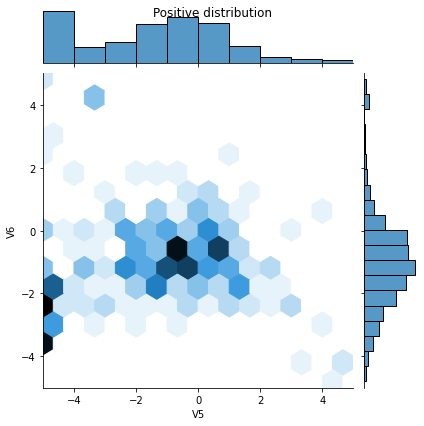

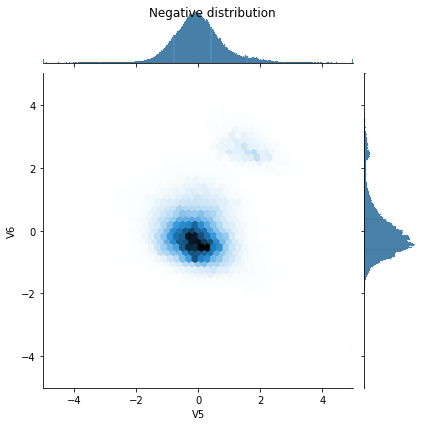

In [11]:
# visualize dists
sns.jointplot(
    pos_df['V5'], pos_df['V6'],
    kind='hex', xlim=(-5,5), ylim=(-5,5)
);

plt.suptitle("Positive distribution")
sns.jointplot(
    neg_df['V5'], neg_df['V6'],
    kind='hex', xlim=(-5,5), ylim=(-5,5)
);

_ = plt.suptitle("Negative distribution")

plt.show()

---
# Define the model and metrics

In [12]:
# define metrics
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),
]

METRICS

In [13]:
# define function to create model
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model

---
# Baseline model

In [14]:
# set model params
EPOCHS = 100
BATCH_SIZE = 2048 # large batch size to ensure some positive samples

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [15]:
# make model
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [16]:
# predict
model.predict(train_features[:10])

array([[0.60364646],
       [0.957233  ],
       [0.8594864 ],
       [0.8233329 ],
       [0.68063724],
       [0.87865233],
       [0.8776762 ],
       [0.88091385],
       [0.39885274],
       [0.9421957 ]], dtype=float32)

In [17]:
# evaluate baseline
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.9668


In [18]:
# set initial bias
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [19]:
# use bias and remake
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0142


In [20]:
# keep initialized weights
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [21]:
# # test to see if smart bias initialization works
# model = make_model()
# model.load_weights(initial_weights)
# model.layers[-1].bias.assign([0.0])
# zero_bias_history = model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     epochs=20,
#     validation_data=(val_features, val_labels), 
#     verbose=0)

# model = make_model()
# model.load_weights(initial_weights)
# careful_bias_history = model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     epochs=20,
#     validation_data=(val_features, val_labels), 
#     verbose=0)

# def plot_loss(history, label, n):
#   # Use a log scale on y-axis to show the wide range of values.
#   plt.semilogy(history.epoch, history.history['loss'],
#                color=colors[n], label='Train ' + label)
#   plt.semilogy(history.epoch, history.history['val_loss'],
#                color=colors[n], label='Val ' + label,
#                linestyle="--")
#   plt.xlabel('Epoch')
#   plt.ylabel('Loss')

# plot_loss(zero_bias_history, "Zero Bias", 0)
# plot_loss(careful_bias_history, "Careful Bias", 1)

In [22]:
# train model
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels)
)

Epoch 1/100
90/90 [==============================] - 4s 22ms/step - loss: 0.0158 - tp: 440.0000 - fp: 179198.0000 - tn: 366613.0000 - fn: 577.0000 - accuracy: 0.6712 - precision: 0.0024 - recall: 0.4326 - auc: 0.7175 - prc: 0.0266 - val_loss: 0.0056 - val_tp: 31.0000 - val_fp: 8.0000 - val_tn: 45497.0000 - val_fn: 33.0000 - val_accuracy: 0.9991 - val_precision: 0.7949 - val_recall: 0.4844 - val_auc: 0.9215 - val_prc: 0.6567
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0089 - tp: 143.0000 - fp: 39.0000 - tn: 181898.0000 - fn: 196.0000 - accuracy: 0.9987 - precision: 0.7857 - recall: 0.4218 - auc: 0.8826 - prc: 0.4706 - val_loss: 0.0047 - val_tp: 35.0000 - val_fp: 9.0000 - val_tn: 45496.0000 - val_fn: 29.0000 - val_accuracy: 0.9992 - val_precision: 0.7955 - val_recall: 0.5469 - val_auc: 0.9196 - val_prc: 0.6871
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0071 - tp: 168.0000 - fp: 35.0000 - tn: 181902.0000 - fn: 171.0000 - acc

In [23]:
# function to plot metrics
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(
            history.epoch, 
            history.history[metric], 
            color=colors[0], 
            label='Train'
        )
        plt.plot(
            history.epoch, 
            history.history['val_'+metric], 
            color=colors[0], 
            linestyle="--", 
            label='Val'
        )
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
    if metric == 'loss': 
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc': 
        plt.ylim([0.8,1])
    else: 
        plt.ylim([0,1])
        
    plt.legend()

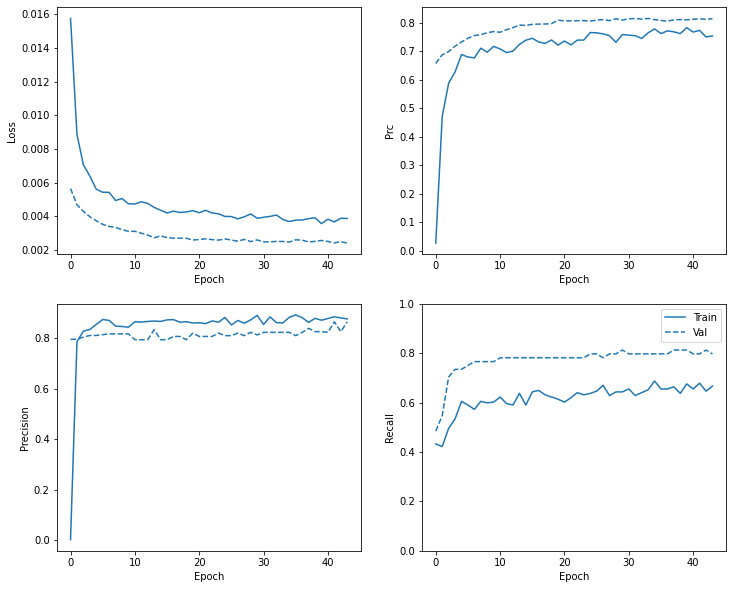

In [24]:
# plot metrics by epochs
plot_metrics(baseline_history)

---
# Evaluate baseline metrics

In [25]:
# train vs test predictions
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [26]:
# function to plot confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')    

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    print('')

    plt.show()

loss :  0.0028336592949926853
tp :  69.0
fp :  10.0
tn :  56863.0
fn :  20.0
accuracy :  0.9994733333587646
precision :  0.8734177350997925
recall :  0.7752808928489685
auc :  0.9265946745872498
prc :  0.8125500679016113

Legitimate Transactions Detected (True Negatives):  56863
Legitimate Transactions Incorrectly Detected (False Positives):  10
Fraudulent Transactions Missed (False Negatives):  20
Fraudulent Transactions Detected (True Positives):  69
Total Fraudulent Transactions:  89



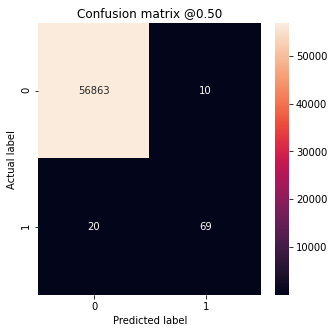

In [27]:
# evaluate baseline with confusion matrix
baseline_results = model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE, verbose=0
)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

print('')

plot_cm(test_labels, test_predictions_baseline)

In [28]:
# function to plot ROC
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

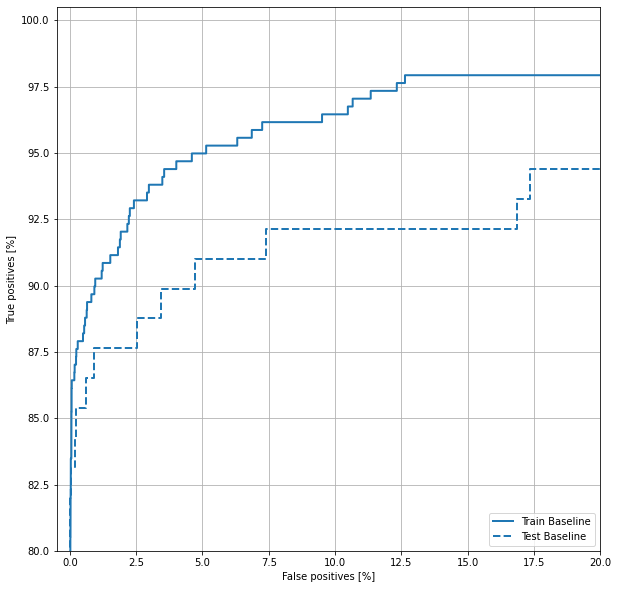

In [29]:
# plot roc
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [30]:
# funection to plot auc
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

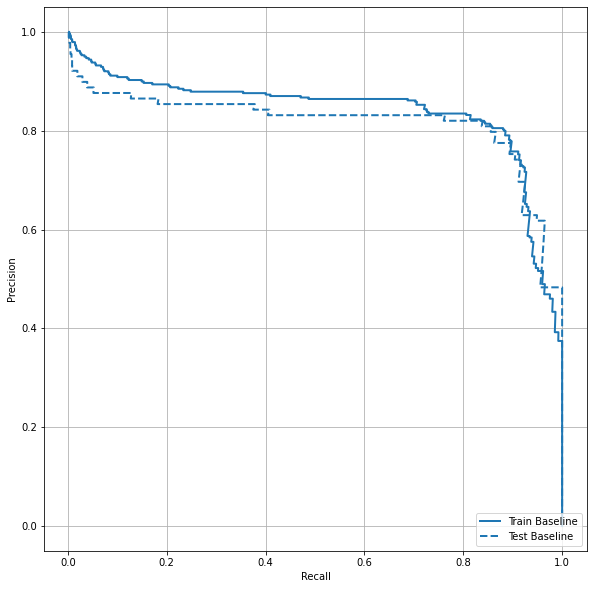

In [31]:
# plot auc
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

---
# Class weighting approach

In [32]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [33]:
# retrain model with class weight
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight
)

Epoch 1/100
90/90 [==============================] - 4s 22ms/step - loss: 1.1255 - tp: 223.0000 - fp: 1352.0000 - tn: 237458.0000 - fn: 205.0000 - accuracy: 0.9935 - precision: 0.1416 - recall: 0.5210 - auc: 0.8807 - prc: 0.2263 - val_loss: 0.0183 - val_tp: 51.0000 - val_fp: 76.0000 - val_tn: 45429.0000 - val_fn: 13.0000 - val_accuracy: 0.9980 - val_precision: 0.4016 - val_recall: 0.7969 - val_auc: 0.9307 - val_prc: 0.5676
Epoch 2/100
90/90 [==============================] - 1s 11ms/step - loss: 0.5178 - tp: 245.0000 - fp: 2467.0000 - tn: 179470.0000 - fn: 94.0000 - accuracy: 0.9859 - precision: 0.0903 - recall: 0.7227 - auc: 0.9294 - prc: 0.3336 - val_loss: 0.0277 - val_tp: 52.0000 - val_fp: 152.0000 - val_tn: 45353.0000 - val_fn: 12.0000 - val_accuracy: 0.9964 - val_precision: 0.2549 - val_recall: 0.8125 - val_auc: 0.9451 - val_prc: 0.6298
Epoch 3/100
90/90 [==============================] - 1s 11ms/step - loss: 0.4191 - tp: 265.0000 - fp: 3598.0000 - tn: 178339.0000 - fn: 74.0000 - 

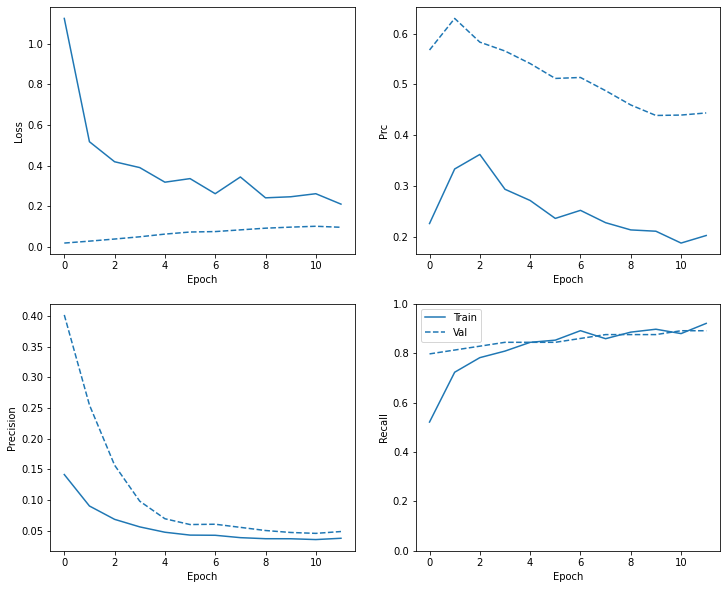

In [34]:
# check new model metrics
plot_metrics(weighted_history)

In [35]:
# train vs test prediction, weighted
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.028419649228453636
tp :  74.0
fp :  232.0
tn :  56641.0
fn :  15.0
accuracy :  0.9956637620925903
precision :  0.24183006584644318
recall :  0.8314606547355652
auc :  0.9245745539665222
prc :  0.6175689101219177

Legitimate Transactions Detected (True Negatives):  56641
Legitimate Transactions Incorrectly Detected (False Positives):  232
Fraudulent Transactions Missed (False Negatives):  15
Fraudulent Transactions Detected (True Positives):  74
Total Fraudulent Transactions:  89



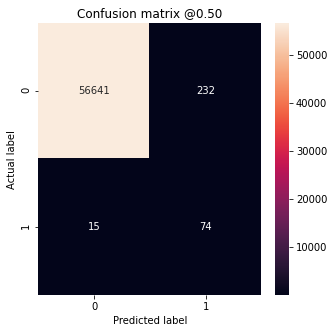

In [36]:
# evaluate new weighted model
weighted_results = weighted_model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE, verbose=0
)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

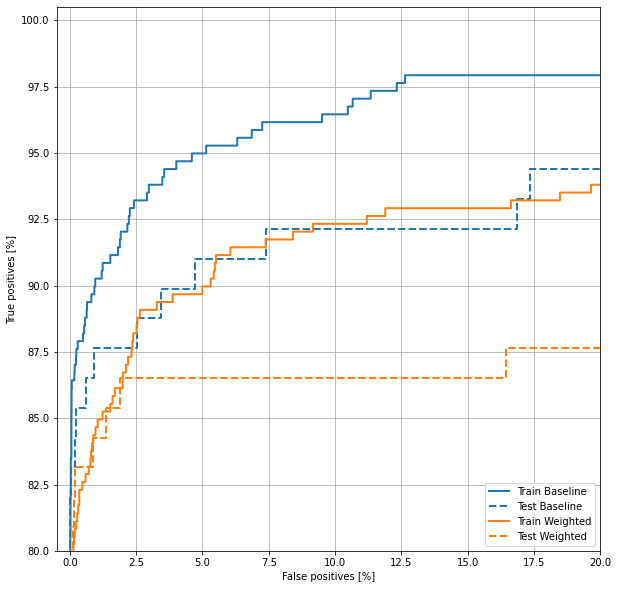

In [37]:
# plot weighted model roc vs baseline
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

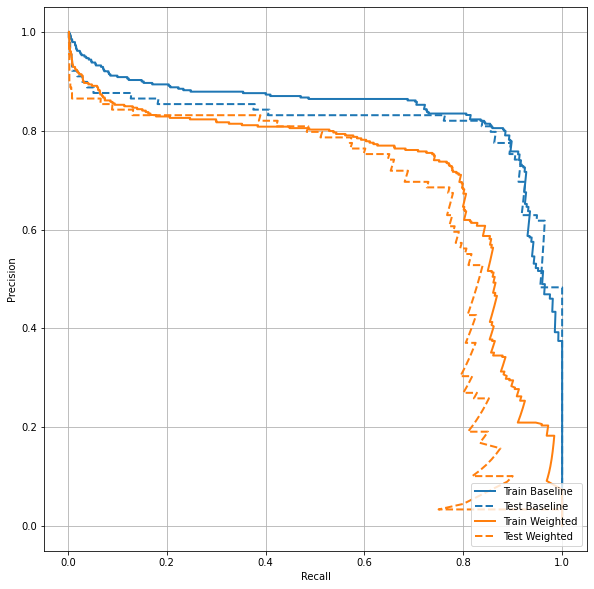

In [38]:
# plot weighted model auc vs baseline
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

---
# Oversampling approach

In [39]:
# set pos vs neg features and labels
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]
pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [40]:
# use tf.data to rebalance data
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [41]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [-5.          3.61987749 -5.          5.         -5.         -2.68435823
 -5.          5.         -5.         -5.          5.         -5.
  1.04005439 -5.          1.13650519 -5.         -5.         -5.
  3.83174292 -0.05941554  3.52043237  0.28695705 -2.73942918  0.92163623
 -0.05371628  0.73260873  0.67603604 -0.46964821 -4.87052567]

Label:  1


In [42]:
# merge
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

Instructions for updating:
Use `tf.data.Dataset.random(...)`.


In [43]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.51025390625


In [44]:
# create balanced number of steps per epoch
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [45]:
# train  on the oversampled data
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds
)

Epoch 1/100
278/278 [==============================] - 24s 80ms/step - loss: 0.4234 - tp: 264498.0000 - fp: 104847.0000 - tn: 236513.0000 - fn: 20448.0000 - accuracy: 0.7999 - precision: 0.7161 - recall: 0.9282 - auc: 0.9424 - prc: 0.9474 - val_loss: 0.2704 - val_tp: 59.0000 - val_fp: 1853.0000 - val_tn: 43652.0000 - val_fn: 5.0000 - val_accuracy: 0.9592 - val_precision: 0.0309 - val_recall: 0.9219 - val_auc: 0.9878 - val_prc: 0.6711
Epoch 2/100
278/278 [==============================] - 22s 79ms/step - loss: 0.2025 - tp: 265173.0000 - fp: 20069.0000 - tn: 264464.0000 - fn: 19638.0000 - accuracy: 0.9303 - precision: 0.9296 - recall: 0.9310 - auc: 0.9764 - prc: 0.9818 - val_loss: 0.1360 - val_tp: 59.0000 - val_fp: 1047.0000 - val_tn: 44458.0000 - val_fn: 5.0000 - val_accuracy: 0.9769 - val_precision: 0.0533 - val_recall: 0.9219 - val_auc: 0.9839 - val_prc: 0.6752
Epoch 3/100
278/278 [==============================] - 21s 77ms/step - loss: 0.1548 - tp: 267402.0000 - fp: 11404.0000 - tn: 

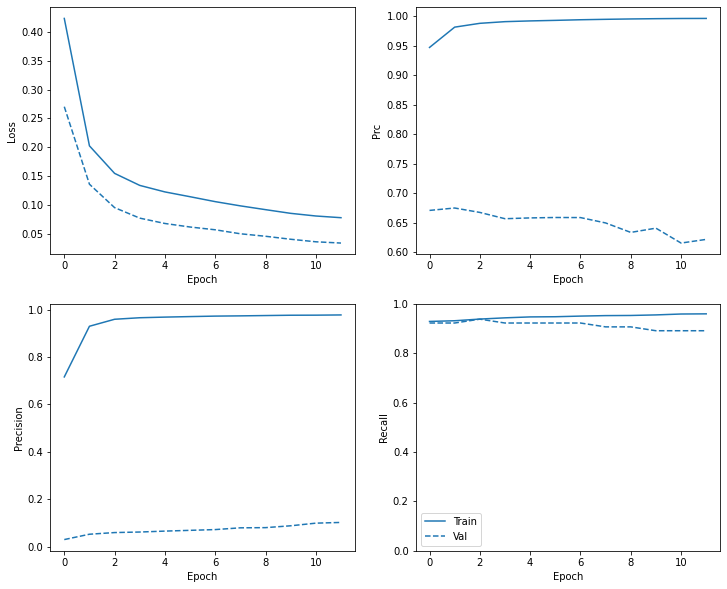

In [46]:
# check balanced model metrics
plot_metrics(resampled_history)

In [46]:
# retrain
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds)
)

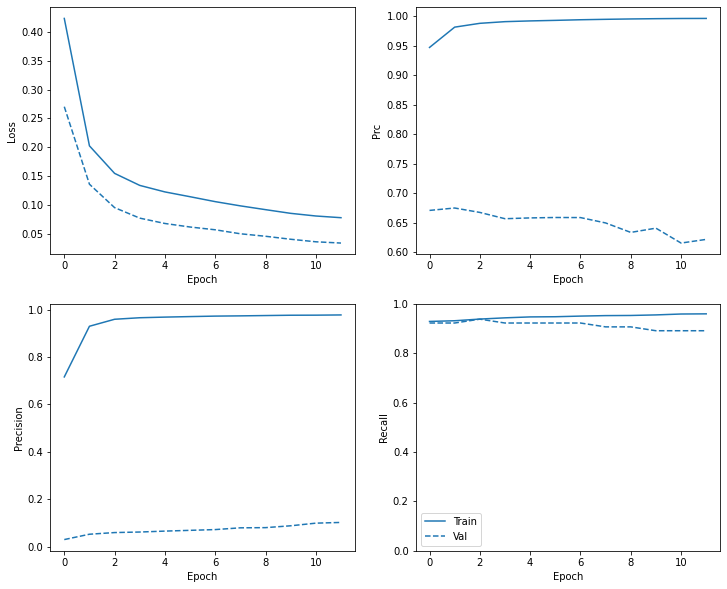

In [47]:
# recheck
plot_metrics(resampled_history)

In [48]:
# train vs test prediction, balanced model
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.13640591502189636
tp :  78.0
fp :  1337.0
tn :  55536.0
fn :  11.0
accuracy :  0.9763351082801819
precision :  0.05512367561459541
recall :  0.8764045238494873
auc :  0.9732178449630737
prc :  0.7184613943099976

Legitimate Transactions Detected (True Negatives):  55536
Legitimate Transactions Incorrectly Detected (False Positives):  1337
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  78
Total Fraudulent Transactions:  89



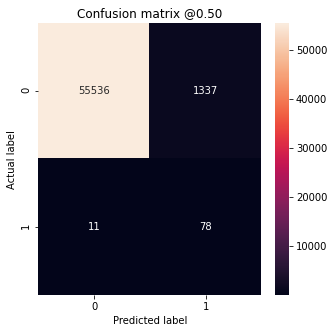

In [49]:
# evalaute balanced model
resampled_results = resampled_model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE, verbose=0
)

for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

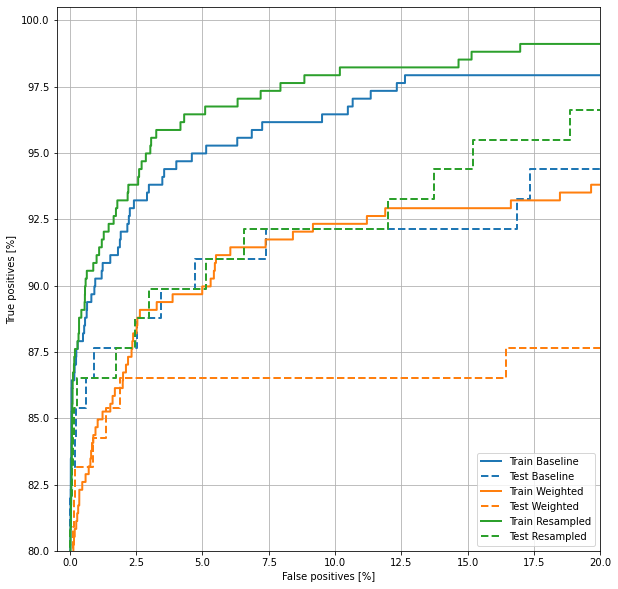

In [50]:
# plot roc
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

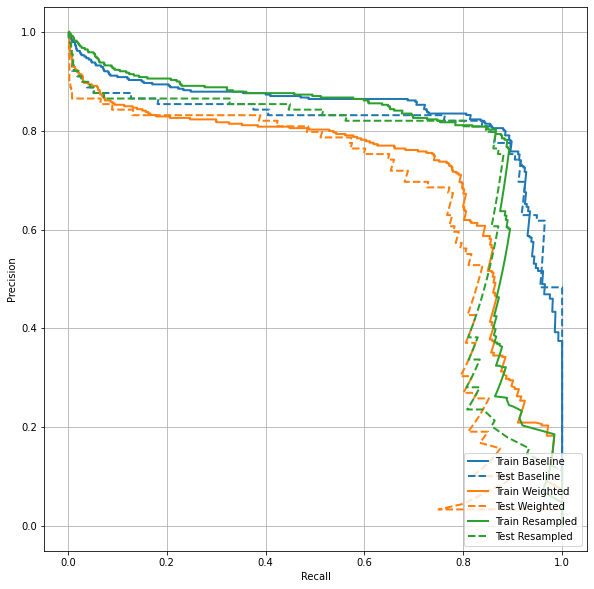

In [51]:
# plot auc
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')